<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/soft_decision_tree_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def plotit(X, Y=None, clf=None, conts=None, ccolors=('b','k','r'), colors=('c','y'), markers=('s','o'), hold=False, transform=None, extent=None, **kwargs):
    eps = 1e-6
    d0, d1 = (0,1)
    if extent is None:
        minx, maxx = np.min(X[:,d0])-eps, np.max(X[:,d0])+eps
        miny, maxy = np.min(X[:,d1])-eps, np.max(X[:,d1])+eps
        extent = [minx, maxx, miny, maxy]
    else:
        [minx, maxx, miny, maxy] = extent

    if clf is not None:
        npts = 150
        x = np.linspace(minx, maxx, npts)
        y = np.linspace(miny, maxy, npts)
        t = np.array(list(itertools.product(x, y)))
        if transform is not None:
            t = transform(t)
        z = clf(t, **kwargs)
        z = np.reshape(z, (npts, npts)).T
        plt.contour(x, y, z, conts, linewidths=[2], colors=ccolors, extent=extent, label='f(x)=0')
        plt.pcolormesh(x, y, z, cmap=plt.cm.Purples, vmin=0, vmax=2)
        plt.colorbar()
        plt.axis(extent)

    if Y is not None:
        classes = sorted(set(Y))
        for i, y in enumerate(classes):
            plt.scatter(X[Y==y, d0], X[Y==y, d1], marker=markers[i%len(markers)], c=colors[i%len(colors)], s=50)

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    if not hold:
        plt.grid()
        plt.show()
    return extent


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class DecisionNode(nn.Module):
    def __init__(self, input_dim):
        super(DecisionNode, self).__init__()
        self.weight = nn.Parameter(torch.randn(input_dim))
        self.bias = nn.Parameter(torch.randn(1))
        self.left = None  # Left child
        self.right = None  # Right child
        self.tau = 0.001
    def forward(self, x):
        return torch.sigmoid((torch.matmul(x, self.weight) + self.bias)/self.tau)

class DecisionTree(nn.Module):
    def __init__(self, input_dim, depth=3, num_classes=2):
        super(DecisionTree, self).__init__()
        self.depth = depth
        self.num_classes = num_classes
        self.root = self.build_tree(input_dim, depth)
        self.leaf_logits = nn.Parameter(torch.randn(2 ** depth, num_classes))

    def build_tree(self, input_dim, depth):
        if depth == 0:
            return None
        node = DecisionNode(input_dim)
        node.left = self.build_tree(input_dim, depth - 1)
        node.right = self.build_tree(input_dim, depth - 1)
        return node

    def traverse_tree(self, node, x, path_probs):
        if node is None:
            return path_probs
        decision = node.forward(x)
        left_prob = path_probs * decision
        right_prob = path_probs * (1 - decision)

        if node.left is None and node.right is None:
            return torch.stack([left_prob, right_prob], dim=-1)

        left_path = self.traverse_tree(node.left, x, left_prob)
        right_path = self.traverse_tree(node.right, x, right_prob)
        return torch.cat([left_path, right_path], dim=-1)

    def forward(self, x):
        batch_size = x.size(0)
        path_probs = torch.ones(batch_size, device=x.device)
        leaf_probs = self.traverse_tree(self.root, x, path_probs)
        logits = torch.matmul(leaf_probs, self.leaf_logits)
        return logits

    def compute_loss(self, x, y, lambda_tree=0.01):
        logits = self.forward(x)
        classification_loss = F.cross_entropy(logits, y)
        tree_complexity = sum(torch.sum(torch.abs(p)) for p in self.parameters())
        total_loss = classification_loss + lambda_tree * tree_complexity
        return total_loss

    def compute_accuracy(self, x, y):
        logits = self.forward(x)
        predictions = torch.argmax(logits, dim=1)
        accuracy = (predictions == y).float().mean()
        return accuracy.item()

# Generate 2D demo dataset
X, y = make_moons(n_samples=300, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Train the decision tree
input_dim = 2  # 2D dataset
num_classes = 2  # Binary classification
depth = 5  # Depth of the tree

model = DecisionTree(input_dim, depth, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    loss = model.compute_loss(X_train_tensor, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        train_accuracy = model.compute_accuracy(X_train_tensor, y_train_tensor)
        test_accuracy = model.compute_accuracy(X_test_tensor, y_test_tensor)
        print(f"Epoch {epoch}, Loss: {loss.item()}, Train Accuracy: {train_accuracy * 100:.2f}%, Test Accuracy: {test_accuracy * 100:.2f}%")

# Explanation:
# This implementation builds a decision tree where each node makes a decision based on a learned weight and bias.
# The tree is trained using a synthetic 2D dataset from sklearn (moons dataset).
# The dataset is normalized using StandardScaler and split into training and testing sets.
# Training minimizes a loss function combining classification error and tree complexity.


Epoch 0, Loss: 1.9776322841644287, Train Accuracy: 65.42%, Test Accuracy: 61.67%
Epoch 10, Loss: 1.6845550537109375, Train Accuracy: 80.42%, Test Accuracy: 80.00%
Epoch 20, Loss: 1.5089161396026611, Train Accuracy: 82.50%, Test Accuracy: 83.33%
Epoch 30, Loss: 1.3737506866455078, Train Accuracy: 82.50%, Test Accuracy: 86.67%
Epoch 40, Loss: 1.2607386112213135, Train Accuracy: 82.50%, Test Accuracy: 88.33%
Epoch 50, Loss: 1.1453850269317627, Train Accuracy: 86.25%, Test Accuracy: 88.33%
Epoch 60, Loss: 1.0479170083999634, Train Accuracy: 86.25%, Test Accuracy: 88.33%
Epoch 70, Loss: 0.9587448835372925, Train Accuracy: 92.92%, Test Accuracy: 90.00%
Epoch 80, Loss: 0.8830206394195557, Train Accuracy: 93.33%, Test Accuracy: 90.00%
Epoch 90, Loss: 0.8198895454406738, Train Accuracy: 93.33%, Test Accuracy: 90.00%


<ipython-input-28-d21783d9f931>:31: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x, y, z, conts, linewidths=[2], colors=ccolors, extent=extent, label='f(x)=0')


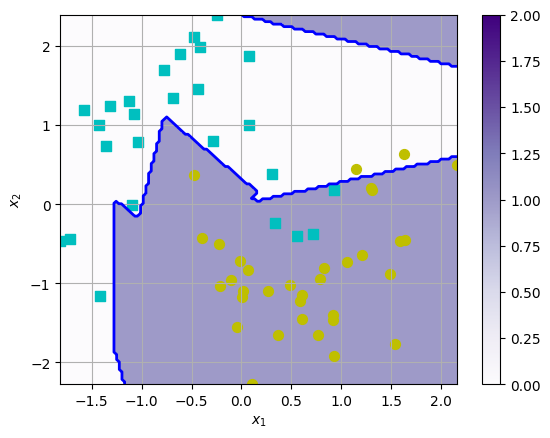

[-1.816066722881887, 2.159242060239376, -2.27901883201439, 2.3980075313378446]

In [34]:
def clf_predict(X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        return model.forward(X_tensor).numpy().argmax(axis=1)

plotit(X_test, y_test, clf=clf_predict, conts=[0.2])

In [17]:
np.max(clf_predict(X))

1.8737096